<a href="https://colab.research.google.com/github/bedhinesh/capstone-aiml/blob/dhinesh/Validate_train_test_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
#Import Libraries
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Initialize the random number generator
import random
random.seed(0)

#Tensor Flow
import tensorflow
tensorflow.__version__

#Matplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

#Importing drive
from google.colab import drive
#OS
import os
#Numpy
import numpy as np
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
#Pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
from wordcloud import WordCloud

#CV2
import cv2

#Image data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [3]:
#Mount Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
project_path = '/content/drive/My Drive/kaggle/'
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [6]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=044b42bccb9b1c77afaa497bd1e64be9c735d03c796d1207f8469cab680e8524
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [16]:
import wget
print('Beginning to download vgg h5 file')

url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
wget.download(url, 'vgg16_weights_tf_dim_ordering_tf_kernels.h5')

Beginning to download vgg h5 file


'vgg16_weights_tf_dim_ordering_tf_kernels.h5'

In [17]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
def _get_predictions(_model,data):
    img = np.expand_dims(data, axis=0)
    #print('expanded image',img)
    img = preprocess_input(img)
    #print('processed image',img)      
    return decode_predictions(_model.predict(img), top=3)[0]

In [18]:
vgg16_weights = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)

In [20]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file


    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]

def extract_file_path(data):
  dataEnriched = pd.DataFrame(data)
  dataEnriched[1]=dataEnriched[0].apply(lambda x: x.image_path().rsplit("/",1)[0])
  dataEnriched[2]=dataEnriched[0].apply(lambda x: x.image_path().rsplit("/",1)[1])
  return dataEnriched

def prepare_annotation_data(data,labels,metaData):
  data[6]=labels[data[5]-1]
  data[7]=data[6].apply(lambda x: x.rsplit(" ",2)[0])
  data[8]=data[6].apply(lambda x: x.rsplit(" ",2)[1])
  data[9]=data[6].apply(lambda x: x.rsplit(" ",2)[2])
  data[10]=data[6].apply(lambda x: x.rsplit(" ",-1)[0])
  pathData = []
  for i in data[0]:
    pathData.append((metaData.loc[metaData[2] == i][0].values)[0])
  data[11] = pathData
  return data

def draw_count_plot(data,column):
  sns.set_style('whitegrid')
  a4_dims = (30, 10)
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.countplot(ax=ax,x=column,data=data, palette='YlGnBu_r',order=data[column].value_counts().index)
  plt.xticks(rotation = 90)
  plt.show()
def draw_word_cloud(data):
  cloudText = ' '.join(data)
  wordcloud = WordCloud().generate(cloudText)
  a4_dims = (30, 10)
  fig, ax = plt.subplots(figsize=a4_dims)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

 


In [21]:
# metadata = load_metadata('images')
trainMetaData = load_metadata('car_data/car_data/train/')
print(trainMetaData.shape)
 
trainMetaDataEnriched=extract_file_path(trainMetaData)
print(trainMetaDataEnriched.shape)
 

(8144,)
(8144, 3)


In [23]:
annotation_train_csv = pd.read_csv('anno_train.csv', header = None)
annotation_test_csv = pd.read_csv('anno_test.csv', header = None)
data_labels = np.array(pd.read_csv('names.csv',header = None))
Train_data = annotation_train_csv.copy()
test_data = annotation_test_csv.copy()

In [24]:
Train_data = prepare_annotation_data(Train_data,data_labels,trainMetaDataEnriched)
print(Train_data.shape)
Train_data.head()


(8144, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,Audi TTS,Coupe,2012,Audi,car_data/car_data/train/Audi TTS Coupe 2012/00001.jpg
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,Acura TL,Sedan,2012,Acura,car_data/car_data/train/Acura TL Sedan 2012/00002.jpg
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,Dodge Dakota Club,Cab,2007,Dodge,car_data/car_data/train/Dodge Dakota Club Cab 2007/00003.jpg
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,Hyundai Sonata Hybrid,Sedan,2012,Hyundai,car_data/car_data/train/Hyundai Sonata Hybrid Sedan 2012/00004.jpg
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,Ford F-450 Super Duty Crew,Cab,2012,Ford,car_data/car_data/train/Ford F-450 Super Duty Crew Cab 2012/00005.jpg


In [25]:
def cropImage(index,data):
    imagedata = data.iloc[index]
    image = load_image(str(imagedata[11]))
    image_height, image_width, _ = image.shape
    fileName = imagedata[0]
    #image = cv2.resize(image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    x1 = int(imagedata[1])
    x2 = int(imagedata[3])
    y1 = int(imagedata[2])
    y2 = int(imagedata[4])
    crop_image = image[y1:y2, x1:x2]
    crop_image = cv2.resize(crop_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    return crop_image

In [26]:
def _get_predictions(_model,data):
    img = np.expand_dims(data, axis=0)
    #print('expanded image',img)
    img = preprocess_input(img)
    #print('processed image',img)      
    return decode_predictions(_model.predict(img), top=3)[0]

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
preds_train = []
for i in range(Train_data[0].size):
    preds_train.append(_get_predictions(vgg16_model,cropImage(i,Train_data)))
    if(i%500==0):
        print("pending images",(Train_data[0].size-i))

40960/35363 [==================================] - 0s 0us/step
pending images 8144
pending images 7644
pending images 7144
pending images 6644
pending images 6144
pending images 5644
pending images 5144
pending images 4644
pending images 4144
pending images 3644
pending images 3144
pending images 2644
pending images 2144
pending images 1644
pending images 1144
pending images 644
pending images 144


In [32]:
str(preds_train[0][0][1])

'sports_car'

In [34]:
from numpy import asarray
from numpy import save
save('preds_train.npy', preds_train)

In [41]:
Pred_train_1 = df = pd.DataFrame(preds_train)

In [43]:
Pred_train_1.head(5)

,0,1,2
0,"(n04285008, sports_car, 0.184406)","(n03100240, convertible, 0.13426176)","(n03459775, grille, 0.083962955)"
1,"(n03770679, minivan, 0.75521624)","(n02814533, beach_wagon, 0.03903571)","(n03445924, golfcart, 0.03608048)"
2,"(n03930630, pickup, 0.94863075)","(n04461696, tow_truck, 0.016081799)","(n03770679, minivan, 0.009046149)"
3,"(n03100240, convertible, 0.3730391)","(n03930630, pickup, 0.20601311)","(n03459775, grille, 0.15916911)"
4,"(n03670208, limousine, 0.43004107)","(n04461696, tow_truck, 0.08250459)","(n04285008, sports_car, 0.07780962)"


In [81]:
Labels_1 = []
Labels_2 = []
Labels_3 = []
for i, row in Pred_train_1.iterrows():
 Labels_1.append(row[0][1])
 Labels_2.append(row[1][1])
 Labels_3.append(row[2][1])
Labels_1[0:10]

['sports_car',
 'minivan',
 'pickup',
 'convertible',
 'limousine',
 'minibus',
 'minivan',
 'sports_car',
 'minivan',
 'minivan']

In [64]:
Labels_2[0:10]

['convertible',
 'beach_wagon',
 'tow_truck',
 'pickup',
 'tow_truck',
 'pickup',
 'police_van',
 'racer',
 'beach_wagon',
 'minibus']

In [67]:
Labels_1_Values, Labels_1_Counts = np.unique(Labels_1, return_counts=True)

print(Labels_1_Values[1:5])
print(Labels_1_Counts[1:5])
print(len(Labels_1_Values))

['ambulance' 'amphibian' 'ashcan' 'beach_wagon']
[ 13   2   1 480]
46


In [69]:
Labels_2_Values, Labels_2_Counts = np.unique(Labels_2, return_counts=True)

In [68]:
Labels_3_Values, Labels_3_Counts = np.unique(Labels_3, return_counts=True)

In [82]:
Labels_1 = pd.DataFrame(Labels_1)
Labels_1.shape

(8144, 1)

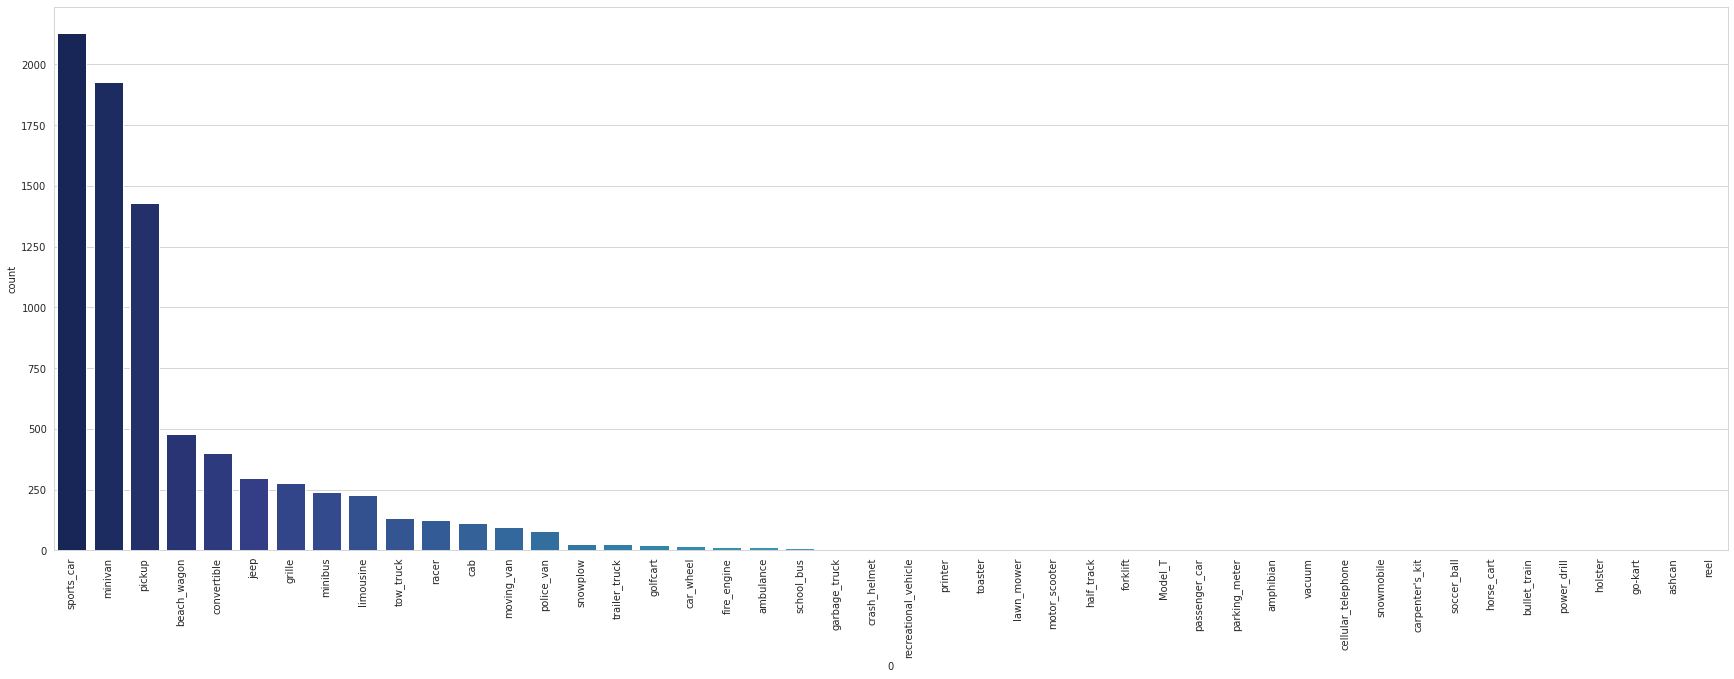

In [88]:

sns.set_style('whitegrid')
a4_dims = (30, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x=Labels_1[0],data=Labels_1, palette='YlGnBu_r',order=Labels_1[0].value_counts().index)
plt.xticks(rotation = 90)
plt.show()
plt.show()

In [91]:
testMetaData = load_metadata('car_data/car_data/test/')
print(testMetaData.shape)
testMetaDataEnriched=extract_file_path(testMetaData)
print(testMetaDataEnriched.shape)
test_data = prepare_annotation_data(test_data,data_labels,testMetaDataEnriched)
print(test_data.shape)

(8041,)
(8041, 3)
(8041, 12)


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
preds_test = []
for i in range(test_data[0].size):
    preds_train.append(_get_predictions(vgg16_model,cropImage(i,test_data)))
    if(i%500==0):
        print("pending images",(test_data[0].size-i))
save('preds_test.npy', preds_test)

pending images 8041
